In [1]:
import numpy as np
import numpy.random as rnd

import matplotlib.pyplot as plt

import sklearn
import sklearn.cluster

In [2]:
def permutations(elems, T):
    def recurse(xs):
        if len(xs[0]) >= T:
            return xs
        else:
            return recurse([x+[e] for x in xs for e in elems]) # + xs
            
    return recurse([[e] for e in elems])

class RndOptionPolicy():
    def __init__(self, n_actions, n_time_steps):
        self.options = np.array(permutations(range(n_actions), n_time_steps))
        
    def __call__(self, x):
        rnd_idx = rnd.choice(np.arange(self.options.shape[0]))
        return self.options[rnd_idx]
     
class OptionEnvWrapper():
    def __init__(self, env):
        self.env = env
        
    def step(self, s, actions):
        R = 0
        for a in actions:
            s, r = self.env.step(s, a)
            R += r
        return s, R

    def reset(self):
        return self.env.reset()

In [3]:
# utils
def onehot(idx, N): # hacky. i know...
    return np.eye(N)[idx]

def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

class Env():
    def __init__(self, n_states, n_actions):
        self.n_states = n_states
        self.S = np.arange(n_states)
        self.A = np.arange(n_actions)

        # model the transitions as linear fns conditional on the action.
        # P = np.random.standard_normal([n_actions, n_states, n_states]) **2 # make sharper

        # deterministic transition fn
        # each action move from state(i) to state(j) with probability 1.
        # BUG nope. softmax doesnt do this. will need to set to -infty
        self.P = 20*np.stack([np.random.permutation(np.eye(n_states, dtype=np.float32)) for _ in range(n_actions-1)] + [np.eye(n_states, dtype=np.float32)],axis=0)  
        # TODO what if there is structure in P? Low rank? Shared over actions?
        # QUESTION how does this parameterisation effect things?
        # NOTE this graph might be disconnected. but is unlikely!?

        # reward is only a fn of the current state - shape = [n_states]
        # also. is sparse.
        self.R = onehot(np.random.randint(0, n_states), n_states)

    def step(self, state, action):
        """
        A tabular, probabilistic step function. 

        Args:
            state (int): An element of S. The current state
            state (int): An element of A. The action to be taken

        Returns:
            new_state (int): An element of S.
        """
        # step by selecting relevant transition matrix and applying
        logits = np.matmul(self.P[action, ...], onehot(state, self.n_states))
        # convert to a distribution and sample
        new_s = np.random.choice(self.S, p=softmax(logits))
        return new_s, self.R[new_s]
    
    def rnd_policy(self, s, *args):
        return np.random.choice(self.A)
    
    def reset(self):
        return np.random.choice(self.S)

    def new_task(self):
        self.R = onehot(np.random.randint(0, self.n_states), self.n_states)

In [4]:
n_actions = 4
n_states = 24
env = Env(n_states, n_actions)
rnd_policy = lambda obs: env.action_space.sample()
op = RndOptionPolicy(n_actions, 6)
env = OptionEnvWrapper(env)
len(op.options), op(2)

(4096, array([2, 3, 0, 1, 0, 3]))

In [5]:
def play_episode(env, player, T=5):
    # reset
    s = env.reset()
    R = 0
    done = False
    pairs = []
    
    # play an episode
    for _ in range(10):

        a = player(s)
        new_s, r = env.step(s, a)
        R += r
        
        pairs.append((np.concatenate([onehot(new_s, n_states), np.array([0])]), 
                      a, 
                      np.concatenate([onehot(new_s, n_states), np.array([R])])))
        s = new_s
            
    return pairs

In [6]:
play_episode(env, op)

[(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0, 0, 2, 2, 3, 3]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.])),
 (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0.]),
  array([1, 2, 2, 1, 1, 1]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0.])),
 (array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1, 1, 0, 2, 0, 1]),
  array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.])),
 (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0.]),
  array([3, 3, 1, 3, 0, 0]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 

In [7]:
def get_pairs():
    pairs = play_episode(env,op)
    pairs = tuple(zip(*pairs))
    return tuple([np.vstack(p) for p in pairs])

In [8]:
def get_n(n):
    pairs = [get_pairs() for i in range(n)]
    pairs = tuple(zip(*pairs))
    return tuple([np.vstack(p) for p in pairs])

In [9]:
get_n(3)[0].shape, get_n(3)[1].shape, get_n(3)[2].shape

((30, 25), (30, 6), (30, 25))

In [10]:
kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=32)

In [14]:
for _ in range(200):
    states = []
    s, p, st = get_n(50)
    kmeans.partial_fit(st-s)

In [15]:
kmeans.cluster_centers_.shape

(32, 25)

(array([  0.,   0.,   0.,   0.,   0., 500.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

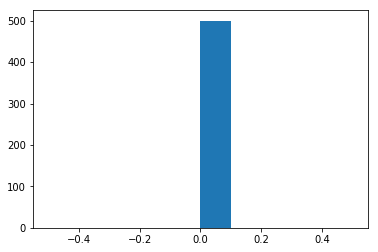

In [16]:
plt.hist(kmeans.predict(s))